In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [111]:
#other useful imports 
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

from utils import featurewise_norm


In [3]:
#ok let's load our usual data 
DATA_PATH = "/home/chengxuz/Class/psych253_2018/data/ventral_neural_data.hdf5"
Ventral_Dataset = h5py.File(DATA_PATH)

In [463]:
Neural_Data = Ventral_Dataset['time_averaged_trial_averaged'][:]
IT_NEURONS = Ventral_Dataset['neural_meta']['IT_NEURONS']
V4_NEURONS = Ventral_Dataset['neural_meta']['V4_NEURONS']
V4_Neural_Data = Neural_Data[:, V4_NEURONS]
IT_Neural_Data = Neural_Data[:, IT_NEURONS]

var_level = Ventral_Dataset['image_meta']['variation_level'][:]
categories = Ventral_Dataset['image_meta']['category'][:]   #array of category labels for all images  --> shape == (5760,)
unique_categories = np.unique(categories)                #array of unique category labels --> shape == (8,)
objects = Ventral_Dataset['image_meta']['object_name'][:]   #array of object labels for all images --> shape == (5670,)
unique_objects = np.unique(objects)                      #array of unique object labels --> shape == (64,) 

objects_by_category = {c: np.unique(objects[categories == c]) 
                       for c in unique_categories}


In [5]:
#use numpy recarray object to store metadata 
meta_array = np.core.records.fromarrays(Ventral_Dataset['image_meta'].values(),
                                        names=Ventral_Dataset['image_meta'].keys())

meta_array.dtype

dtype((numpy.record, [(u'category', 'S7'), (u'image_id', 'S40'), (u'object_name', 'S24'), (u'rotation_xy', '<f8'), (u'rotation_xz', '<f8'), (u'rotation_yz', '<f8'), (u'size', '<f8'), (u'translation_y', '<f8'), (u'translation_z', '<f8'), (u'variation_level', 'S2')]))

In [702]:
subset_inds = ((var_level == 'V6') & ((categories == 'Animals') | (categories == 'Boats'))).nonzero()[0]
Neural_Data_subset = IT_Neural_Data[subset_inds] 
Neural_Data_subset, _ig, _ig = featurewise_norm(Neural_Data_subset)

In [703]:
cov = np.dot(Neural_Data_subset.T, Neural_Data_subset)

In [704]:
cov.shape

(168, 168)

In [705]:
def norm(v): return v / np.linalg.norm(v)

def power_method(X, n=200):
    #initial guess for eigenvector
    k = X.shape[0]
    v = norm(np.random.rand(k))

    #iterate
    for i in range(n):
        #calculate v --> Xv
        v = np.dot(X, v)
        #normalize
        v = norm(v)
        
    #compute corresponding eigenvalue
    l = np.dot(v.T, np.dot(X, v)) / np.dot(v, v)

    return l, v
    

In [706]:
l1, v1 = power_method(cov)

In [707]:
l1

24130.609808875459

In [708]:
test = np.dot(cov, v1)  / v1
test[:10]

array([ 24130.60980888,  24130.60980888,  24130.60980888,  24130.60980888,
        24130.60980888,  24130.60980888,  24130.60980888,  24130.60980888,
        24130.60980888,  24130.60980888])

In [709]:
cov1 = cov - l1 * np.outer(v1.T, v1)

In [710]:
l2, v2 = power_method(cov1)

In [711]:
l2

9291.9253253278966

In [712]:
test = np.dot(cov, v2)  / v2
test[:10]

array([ 9291.92532533,  9291.92532533,  9291.92532533,  9291.92532533,
        9291.92532533,  9291.92532533,  9291.92532533,  9291.92532533,
        9291.92532533,  9291.92532533])

In [713]:
cov2 = cov1 - l2 * np.outer(v2.T, v2)

In [714]:
l3, v3 = power_method(cov2)

In [715]:
l3

5626.2553387756743

In [716]:
test = np.dot(cov, v3)  / v3
test[:10]

array([ 5626.25533878,  5626.25533878,  5626.25533878,  5626.25533878,
        5626.25533878,  5626.25533878,  5626.25533878,  5626.25533878,
        5626.25533878,  5626.25533878])

In [717]:
def get_eigenvalues(X, n=200):
    k = X.shape[0]
    vals = []
    vecs = []
    for i in range(k):
        l, v = power_method(X, n=n)
        vals.append(l)
        vecs.append(v)
        X = X - l * np.outer(v.T, v)
    return np.array(vals), np.array(vecs).T

In [718]:
eigenvals, eigenvecs = get_eigenvalues(cov)

In [719]:
eigenvals_from_numpy, eigenvecs_from_numpy = np.linalg.eig(cov)

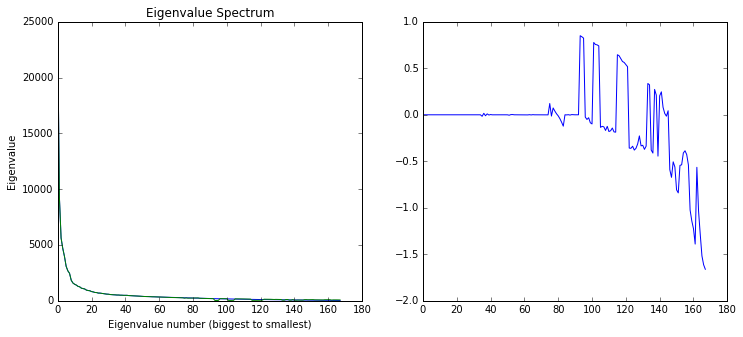

In [720]:
plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.plot(eigenvals)
plt.plot(eigenvals_from_numpy)
plt.ylabel('Eigenvalue')
plt.xlabel('Eigenvalue number (biggest to smallest)')
plt.title('Eigenvalue Spectrum')
plt.subplot(122)
plt.plot((eigenvals - eigenvals_from_numpy) / eigenvals)


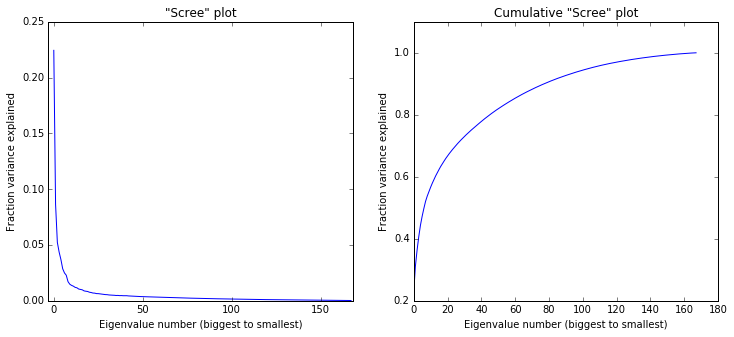

In [721]:
plt.figure(figsize = (12, 5))
plt.subplot(121)
normalized_eigenvals = eigenvals / np.sum(eigenvals)
plt.plot(normalized_eigenvals)
plt.xlim(-3, 168)
plt.ylabel('Fraction variance explained')
plt.xlabel('Eigenvalue number (biggest to smallest)')
plt.title('"Scree" plot')
plt.subplot(122)
plt.plot(normalized_eigenvals.cumsum())
plt.ylabel('Fraction variance explained')
plt.xlabel('Eigenvalue number (biggest to smallest)')
plt.title('Cumulative "Scree" plot')

In [722]:
Xproj = np.dot(Neural_Data_subset, eigenvecs)

(-30.0, 30.0, -15.0, 15.0)

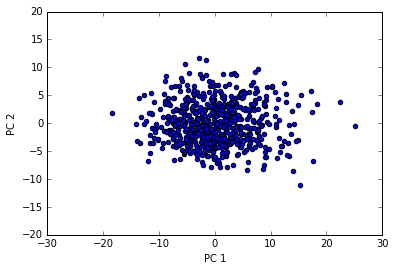

In [723]:
x = Xproj[:, 0]
y = Xproj[:, 1]

plt.scatter(x, y)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.axis('equal')


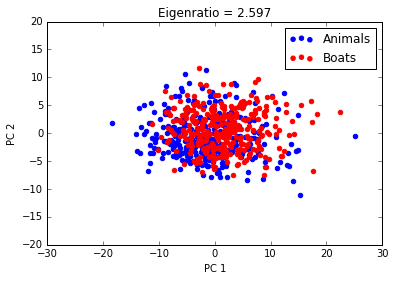

In [736]:
vl = 'V6'
cat1 = 'Animals'
cat2 = 'Boats'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

Neural_Data_subset, _ig, _ig = featurewise_norm(Neural_Data_subset)

cov = np.dot(Neural_Data_subset.T, Neural_Data_subset)

eigenvals, eigenvecs = get_eigenvalues(cov)

eigrat = eigenvals[0] / eigenvals[1]

Xproj = np.dot(Neural_Data_subset, eigenvecs)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title("Eigenratio = %.3f" % eigrat)


In [411]:
#### PCA as a visualization method

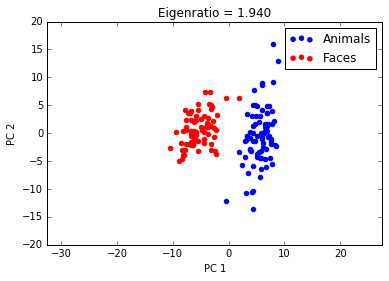

In [727]:
vl = 'V0'
cat1 = 'Animals'
cat2 = 'Faces'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

Neural_Data_subset, _ig, _ig = featurewise_norm(Neural_Data_subset)

cov = np.dot(Neural_Data_subset.T, Neural_Data_subset)

eigenvals, eigenvecs = get_eigenvalues(cov)

eigrat = eigenvals[0] / eigenvals[1]

Xproj = np.dot(Neural_Data_subset, eigenvecs)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title("Eigenratio = %.3f" % eigrat)


### In scikit form

In [753]:
class PCA(object):
    def __init__(self, n_components):
        self.n_components = n_components
        
    def fit(self, train_data):
        data, self.fmean, self.fvar = featurewise_norm(train_data)
        cov = np.dot(data.T, data)
        eigenvals, eigenvecs = get_eigenvalues(cov)
        self.eigenvals = eigenvals
        self.eigenvecs = eigenvecs
        
    def transform(self, test_data):
        data, _ig, _ig = featurewise_norm(test_data, fmean=self.fmean, fvar=self.fvar)
        Xproj = np.dot(data, self.eigenvecs)
        return Xproj[:, :self.n_components]

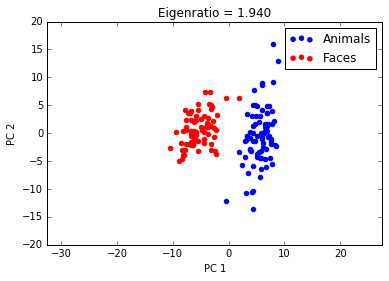

In [754]:
vl = 'V0'
cat1 = 'Animals'
cat2 = 'Faces'
subset_inds1 = ((var_level == vl) & (categories == cat1)).nonzero()[0]
subset_inds2 = ((var_level == vl) & (categories == cat2)).nonzero()[0]
subset_inds = np.concatenate([subset_inds1, subset_inds2])
Neural_Data_subset = IT_Neural_Data[subset_inds]  
category_subset = categories[subset_inds]

cls = PCA(n_components=2)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)
eigrat = cls.eigenvals[0] / cls.eigenvals[1]

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.title("Eigenratio = %.3f" % eigrat)


In [755]:
from sklearn.decomposition import PCA as sklearn_PCA

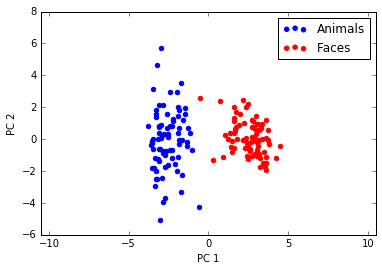

In [756]:
cls = sklearn_PCA(n_components=2)
cls.fit(Neural_Data_subset)

Xproj = cls.transform(Neural_Data_subset)

x = Xproj[:, 0]
y = Xproj[:, 1]

xb = x[category_subset == cat1]
yb = y[category_subset == cat1]
xc = x[category_subset == cat2]
yc = y[category_subset == cat2]
plt.scatter(xb, yb, color='b', label=cat1)
plt.scatter(xc, yc, color='r', label=cat2)
plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
